# Importing Data

In [1]:
import pandas as pd

impacts = pd.read_csv("database.csv", low_memory=False)

# Handling Null Values

In [2]:
impacts = impacts.drop(["Engine1 Position", 
                        "Engine2 Position", 
                        "Engine3 Position", 
                        "Engine4 Position",
                        "Engine Make",
                        "Engine Model",
                        "Engine Type",
                        "Aircraft Make",
                        "Aircraft Model",
                        "Aircraft Mass",
                        "Warning Issued",
                        "Airport",
                        "Distance",
                        "Species ID",
                        "Record ID",
                        "Operator ID"], axis=1)

typeMap = {"A": "Airplane", "B": "Helicopter", "J": "Other"}
impacts["Aircraft Type"] = impacts["Aircraft Type"].map(typeMap).fillna("Unknown")

impacts["Visibility"] = impacts["Visibility"].fillna("UNKNOWN")

impacts["Flight Phase"] = impacts["Flight Phase"].fillna("UNKNOWN")

impacts["Species Quantity"] = impacts["Species Quantity"].fillna("Unknown")

impacts["State"] = impacts["State"].fillna("UNK")

impacts["FAA Region"] = impacts["FAA Region"].fillna("UNK")

impacts["Species Name"] = impacts["Species Name"].fillna("UNKNOWN BIRD")

impacts["Fatalities"] = impacts["Fatalities"].fillna(0)

impacts["Injuries"] = impacts["Injuries"].fillna(0)

# Data Wrangling

In [3]:
def hasEngineStrike(row):
    return int(row['Engine1 Strike']==1 or row['Engine2 Strike']==1 or row['Engine3 Strike']==1 or row['Engine4 Strike']==1)

def hasEngineDamage(row):
    return int(row['Engine1 Damage']==1 or row['Engine2 Damage']==1 or row['Engine3 Damage']==1 or row['Engine4 Damage']==1)

impacts['Engine Strike'] = impacts.apply(lambda row: hasEngineStrike(row), axis=1)
impacts = impacts.drop(['Engine1 Strike', 'Engine2 Strike', 'Engine3 Strike', 'Engine4 Strike'], axis = 1)

impacts['Engine Damage'] = impacts.apply(lambda row: hasEngineDamage(row), axis=1)
impacts = impacts.drop(['Engine1 Damage', 'Engine2 Damage', 'Engine3 Damage', 'Engine4 Damage'], axis = 1)

##################################################

impacts['Height'] = impacts['Height'].divide(3.28084) # feet to m
impacts['Speed'] = impacts['Speed'].multiply(1.852) # knots to km/h

##################################################

impacts["Fog"] = impacts["Precipitation"].str.contains("FOG")
impacts["Rain"] = impacts["Precipitation"].str.contains("RAIN")
impacts["Snow"] = impacts["Precipitation"].str.contains("SNOW")

impacts['Incident Date'] = pd.to_datetime(dict(year=impacts['Incident Year'], 
                                               month=impacts['Incident Month'], 
                                               day=impacts['Incident Day'])).dt.date

impacts = impacts.drop(columns=["Precipitation"])

##################################################

strikeLocations = [
    "Radome Strike", "Windshield Strike", "Nose Strike", "Propeller Strike",
    "Wing or Rotor Strike", "Fuselage Strike", "Landing Gear Strike",
    "Tail Strike", "Lights Strike", "Other Strike", "Engine Strike"
]

damageLocations = [
    "Radome Damage", "Windshield Damage", "Nose Damage", "Propeller Damage",
    "Wing or Rotor Damage", "Fuselage Damage", "Landing Gear Damage",
    "Tail Damage", "Lights Damage", "Other Damage", "Engine Damage"
]

strikeMask = (impacts[strikeLocations] == 0).all(axis=1)
damageMask = (impacts[damageLocations] == 0).all(axis=1)

impacts.loc[strikeMask, "Other Strike"] = 1
impacts.loc[damageMask & (impacts["Aircraft Damage"] == 1), "Other Damage"] = 1

# Statistics

In [4]:
print(f"Date Range Start: {impacts["Incident Date"].min()}")
print(f"Date Range End: {impacts["Incident Date"].max()}")

print()

numImpacts = len(impacts)
numDamage = int(impacts['Aircraft Damage'].sum())
numInjury = int(impacts['Injuries'].sum())
numDeath = int(impacts['Fatalities'].sum())

print(f"Number of Impacts: {numImpacts}")
print(f"Number of Damaged Aircrafts: {numDamage}")
print(f"Number of Injuries: {numInjury}")
print(f"Number of Fatalities: {numDeath}")

print()

print(f"Damaged Aircraft Rate: {round(impacts['Aircraft Damage'].sum()/numImpacts, 2)}")
print(f"Injury Rate: {round(impacts['Injuries'].sum()/numImpacts, 4)}")
print(f"Fatality Rate: {'%f' % round(impacts['Fatalities'].sum()/numImpacts, 5)}")

print()

print(f"Runway Impact Rate: {round((len(impacts[impacts['Height'] == 0])/numImpacts), 2)}")
impactsKnownAnimal = impacts[~impacts['Species Name'].str.contains('UNK')]
print(f"Unknown Animal Rate: {round(1-(len(impactsKnownAnimal)/numImpacts), 2)}")

print()

print('Impact Location Rates:')
round(impacts[strikeLocations].mean().sort_values(ascending=False), 2)

Date Range Start: 1990-01-01
Date Range End: 2015-09-30

Number of Impacts: 174104
Number of Damaged Aircrafts: 14969
Number of Injuries: 400
Number of Fatalities: 26

Damaged Aircraft Rate: 0.09
Injury Rate: 0.0023
Fatality Rate: 0.000150

Runway Impact Rate: 0.24
Unknown Animal Rate: 0.47

Impact Location Rates:


Other Strike            0.38
Windshield Strike       0.14
Nose Strike             0.12
Wing or Rotor Strike    0.12
Radome Strike           0.11
Fuselage Strike         0.10
Engine Strike           0.10
Landing Gear Strike     0.05
Propeller Strike        0.02
Tail Strike             0.01
Lights Strike           0.01
dtype: float64

# Plotting

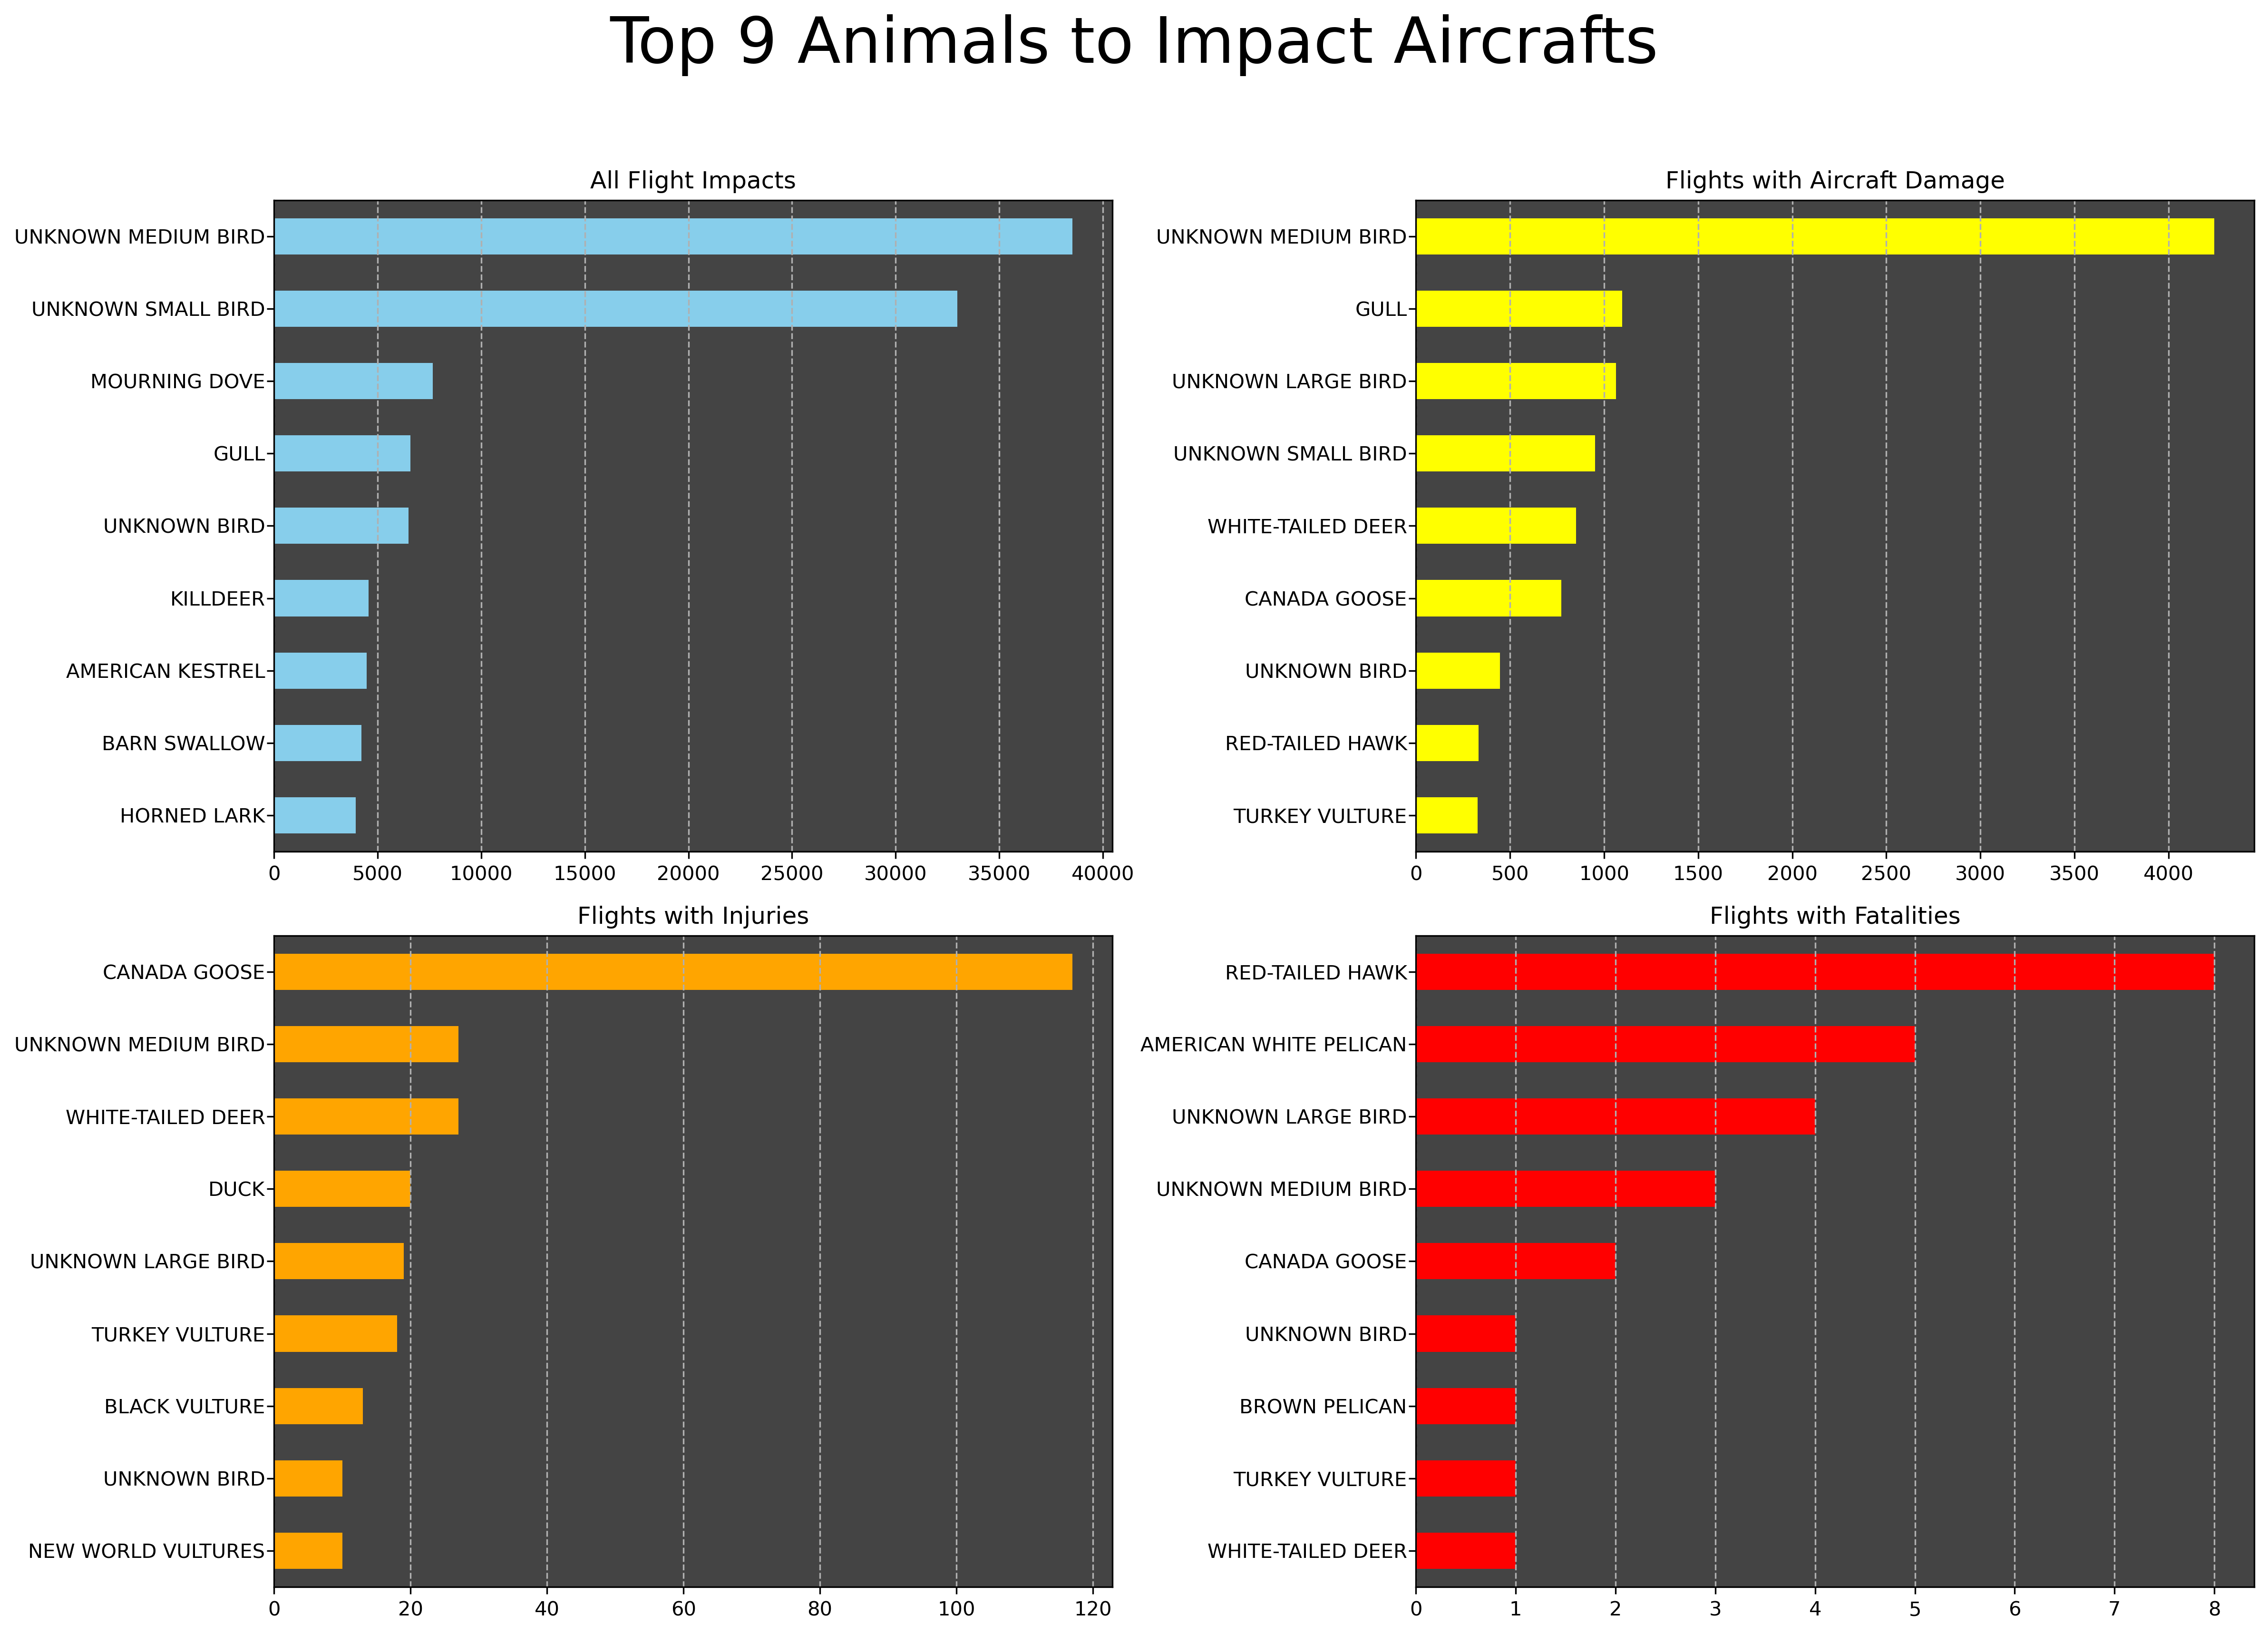

In [5]:
import matplotlib.pyplot as plt

numAnimals = 9

impactColor = "skyblue"
damageColor = "yellow"
injuryColor = "orange"
deathColor = "red"

backgroundColor = "#444444"

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

# Total Aircraft Impacts
totalAnimals = impacts["Species Name"].value_counts()[:numAnimals]
totalAnimals.plot(ax=ax1, kind="barh", title="All Flight Impacts", color=impactColor)

# Damaged Flights
damageAnimals = impacts[["Species Name", "Aircraft Damage"]]
damageAnimals = damageAnimals.groupby(by="Species Name")["Aircraft Damage"].sum().sort_values(ascending=False)[:numAnimals]
damageAnimals.plot(ax=ax2, kind="barh", title="Flights with Aircraft Damage", color=damageColor)

# Injury Flights
injuryAnimals = impacts[["Species Name", "Injuries"]]
injuryAnimals = injuryAnimals.groupby(by="Species Name")["Injuries"].sum().sort_values(ascending=False)[:numAnimals]
injuryAnimals.plot(ax=ax3, kind="barh", title="Flights with Injuries", color=injuryColor)

# Fatal Flights
fatalityAnimals = impacts[["Species Name", "Fatalities"]]
fatalityAnimals = fatalityAnimals.groupby(by="Species Name")["Fatalities"].sum().sort_values(ascending=False)[:numAnimals]
fatalityAnimals.plot(ax=ax4, kind="barh", title="Flights with Fatalities", color=deathColor)

# Apply styling to all subplots
for a in [ax1, ax2, ax3, ax4]:
    a.set_ylabel("")
    a.tick_params(axis="y", which="major", pad=1)
    a.grid(axis="x", which="major", linestyle="--")
    a.invert_yaxis()
    a.set_facecolor(backgroundColor)

fig.patch.set_facecolor("w")
fig.set_size_inches(16, 12)
fig.set_dpi(300)
fig.suptitle(f"Top {numAnimals} Animals to Impact Aircrafts", fontsize=32)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

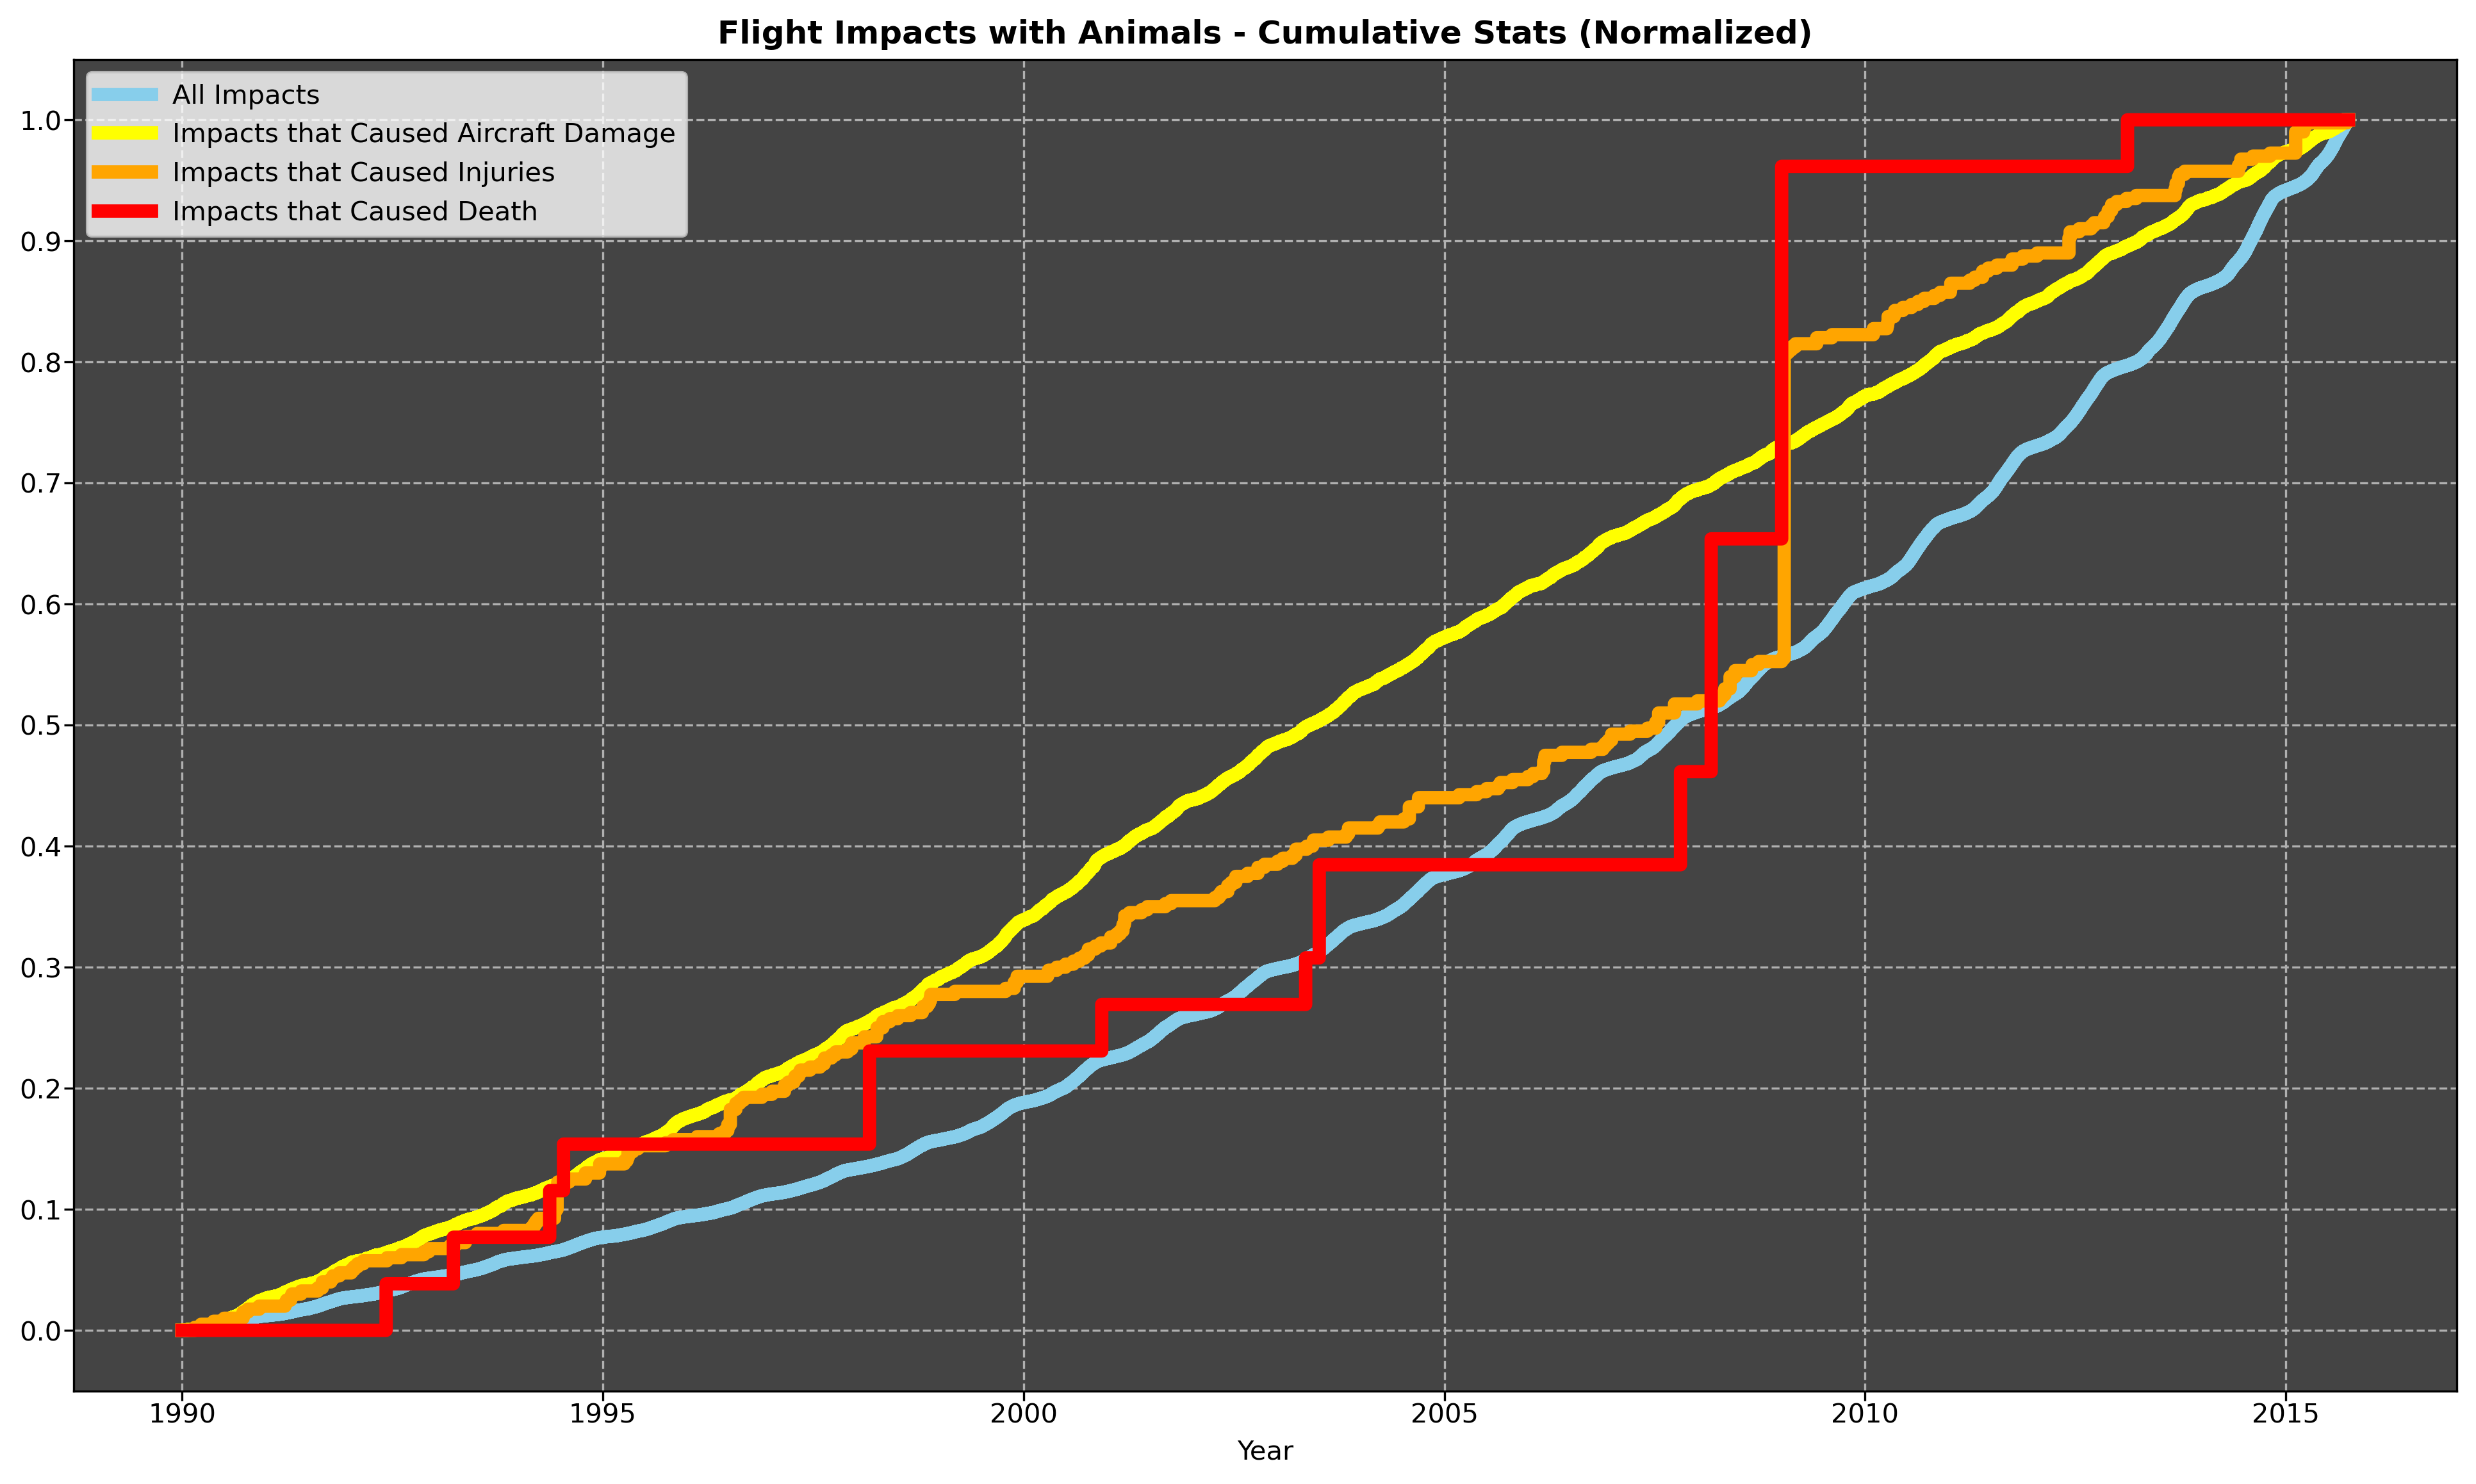

In [6]:
import numpy as np
import matplotlib.dates as mdates

# Cumulative sums
impactCum = np.arange(1, len(impacts) + 1)
damageCum = impacts["Aircraft Damage"].cumsum()
injuryCum = impacts["Injuries"].cumsum()
fatalityCum = impacts["Fatalities"].cumsum()

# Legend labels
impactLabel = f"All Impacts"
damageLabel = f"Impacts that Caused Aircraft Damage"
injuryLabel = f"Impacts that Caused Injuries"
fatalityLabel = f"Impacts that Caused Death"

# Plotting
fig, ax = plt.subplots()
ax.set_title("Flight Impacts with Animals - Cumulative Stats (Normalized)", fontweight="bold")

plt.step(impacts["Incident Date"], impactCum/impactCum.max(), label=impactLabel, linewidth=5, color=impactColor)
plt.step(impacts["Incident Date"], damageCum/damageCum.max(), label=damageLabel, linewidth=5, color=damageColor)
plt.step(impacts["Incident Date"], injuryCum/injuryCum.max(), label=injuryLabel, linewidth=5, color=injuryColor)
plt.step(impacts["Incident Date"], fatalityCum/fatalityCum.max(), label=fatalityLabel, linewidth=5, color=deathColor)

# Formatting X-axis: Ticks every 5 years, no rotation
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=0)

# Styling and Grid
plt.grid(axis="both", which="both", linestyle="--", zorder=-1)
plt.legend(facecolor="w")
plt.locator_params(axis="y", nbins=11)
plt.xlabel("Year")

ax.set_facecolor(backgroundColor)
ax.tick_params(axis="both", which="major", pad=1)

fig.patch.set_facecolor("w")
fig.set_size_inches(16, 9)
fig.set_dpi(300)
plt.show()

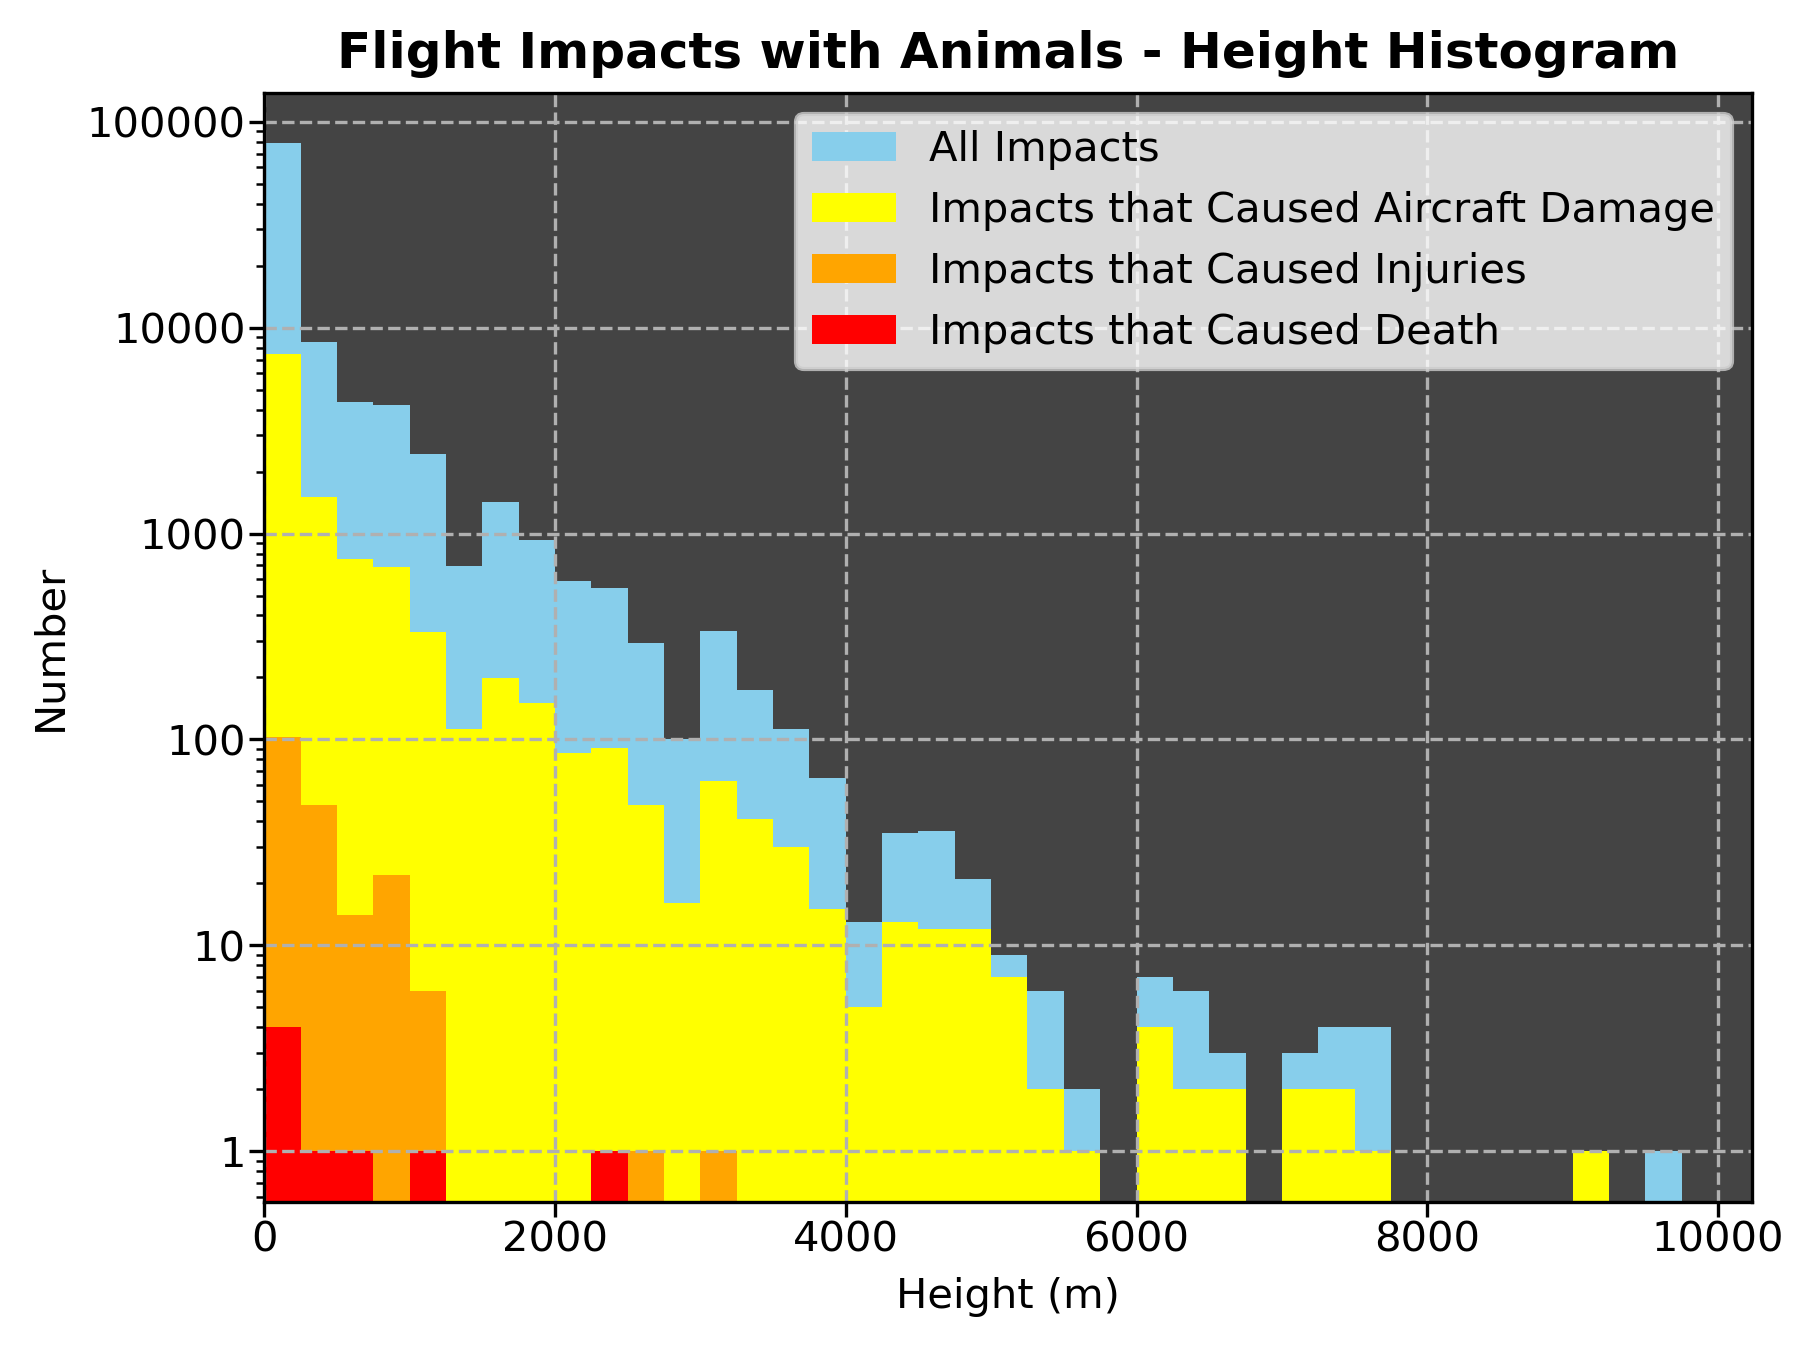

In [7]:
import matplotlib.ticker as mticker

impactsDamaged = impacts[impacts["Aircraft Damage"] > 0]
impactsInjury = impacts[impacts["Injuries"] > 0]
impactsDeath = impacts[impacts["Fatalities"] > 0]

def generateHistogram(col, units, binWidth):
    binMax = int(impacts[col].max()) + binWidth

    fig, ax = plt.subplots()
    ax.set_title(f"Flight Impacts with Animals - {col} Histogram", fontweight="bold")
    ax.set_facecolor(backgroundColor)
    
    # Updated to remove edgecolor and match your naming style
    plt.hist(impacts[col], bins=range(0, binMax, binWidth), label=impactLabel, color=impactColor)
    plt.hist(impactsDamaged[col], bins=range(0, binMax, binWidth), label=damageLabel, color=damageColor)
    plt.hist(impactsInjury[col], bins=range(0, binMax, binWidth), label=injuryLabel, color=injuryColor)
    plt.hist(impactsDeath[col], bins=range(0, binMax, binWidth), label=fatalityLabel, color=deathColor)
    
    ax.set_yscale("log")
    plt.grid(axis="both", which="major", linestyle="--")
    
    # Formatting Y-axis to show actual numbers instead of scientific notation
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.0f"))
    
    plt.xlabel(f"{col} ({units})")
    plt.ylabel("Number")
    ax.tick_params(axis="both", which="major", pad=1)
    
    fig.patch.set_facecolor("w")
    fig.set_dpi(300)

    if col == "Speed":
        ax.set_xlim(left=0, right=1000)
    else:
        ax.set_xlim(left=0)

    plt.legend(facecolor="w")
    plt.show()

# Generating the plot
generateHistogram("Height", "m", 250)

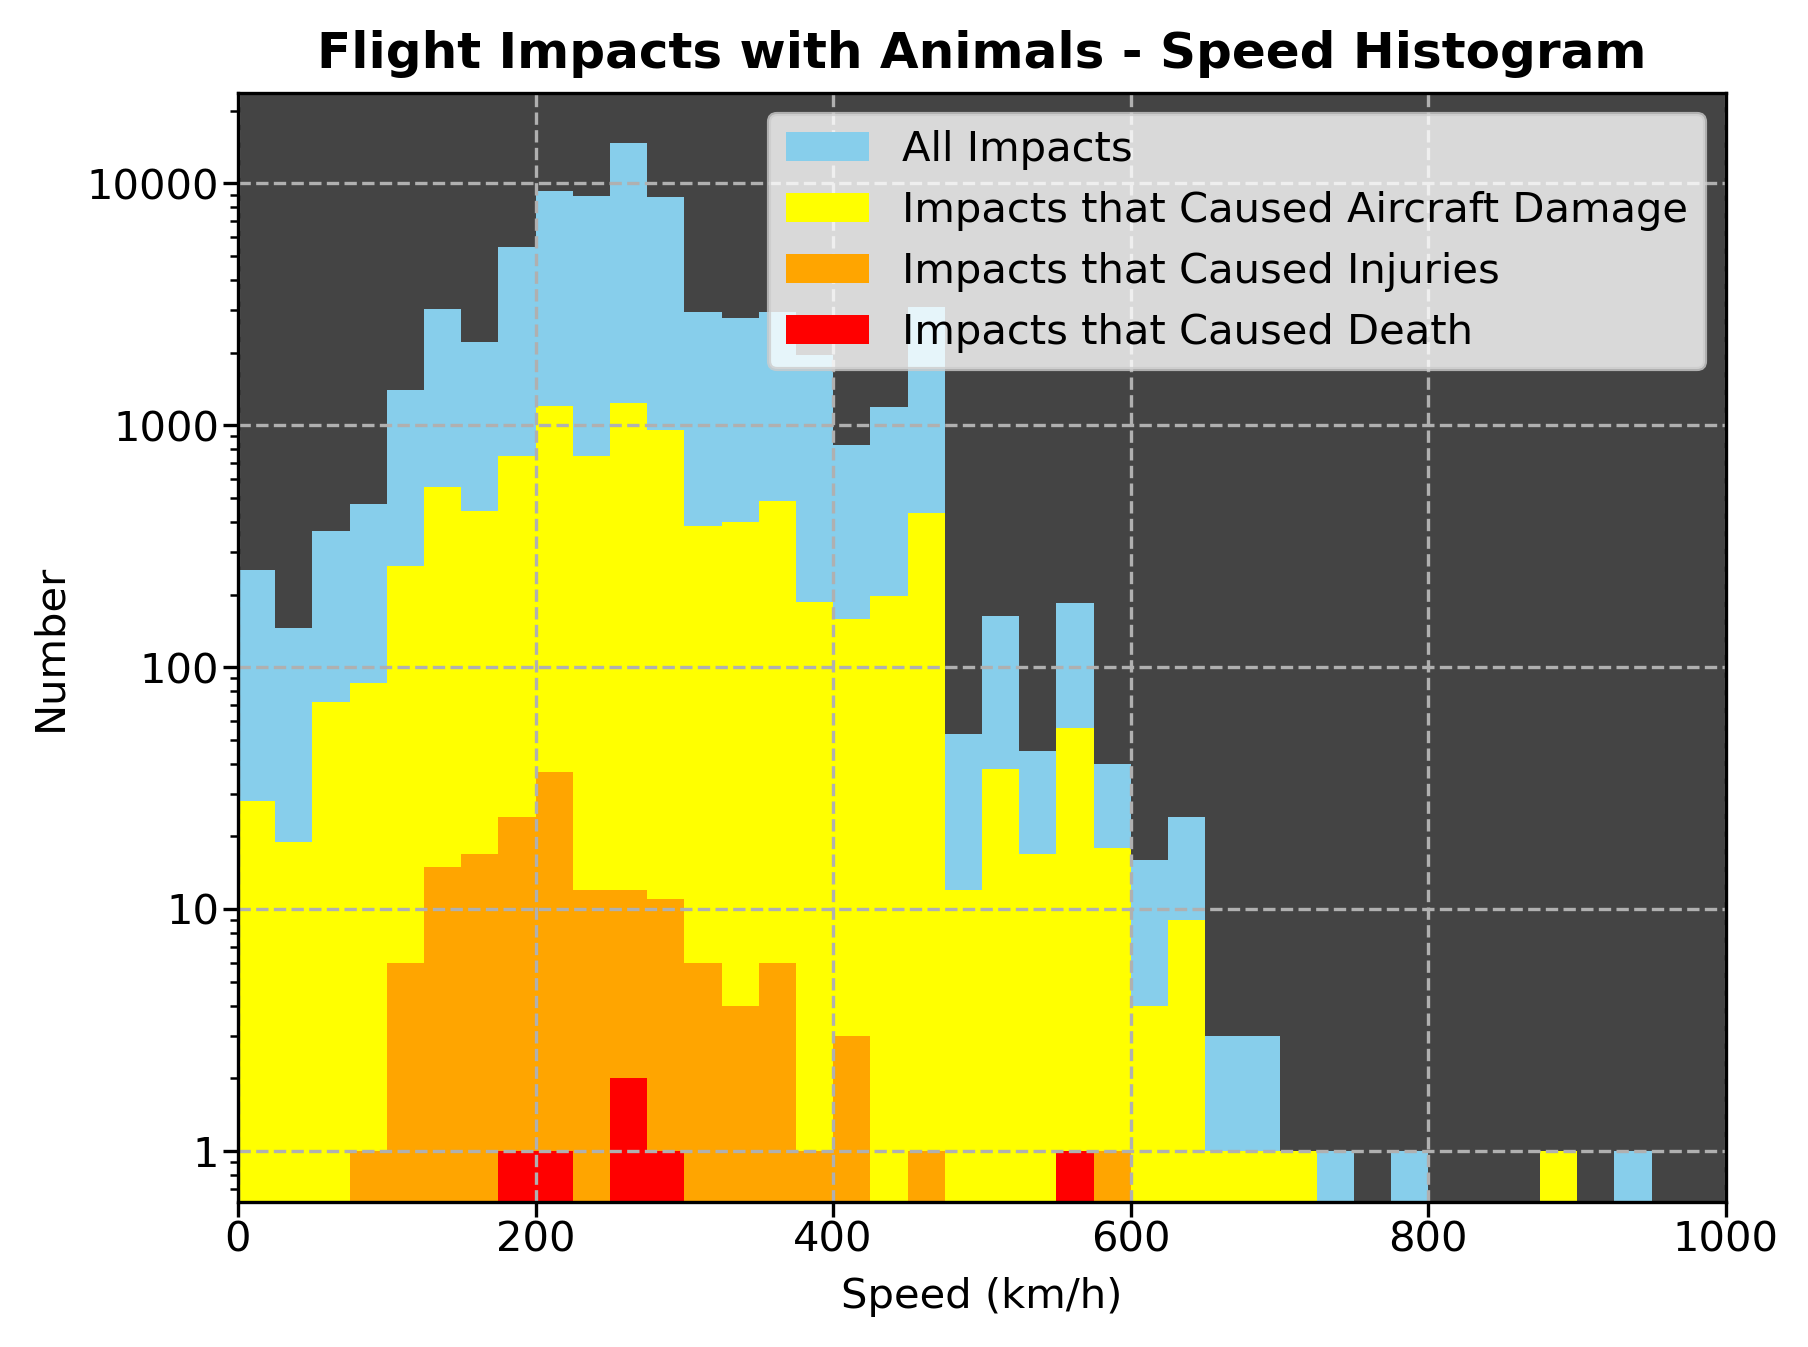

In [8]:
generateHistogram('Speed', 'km/h', 25)

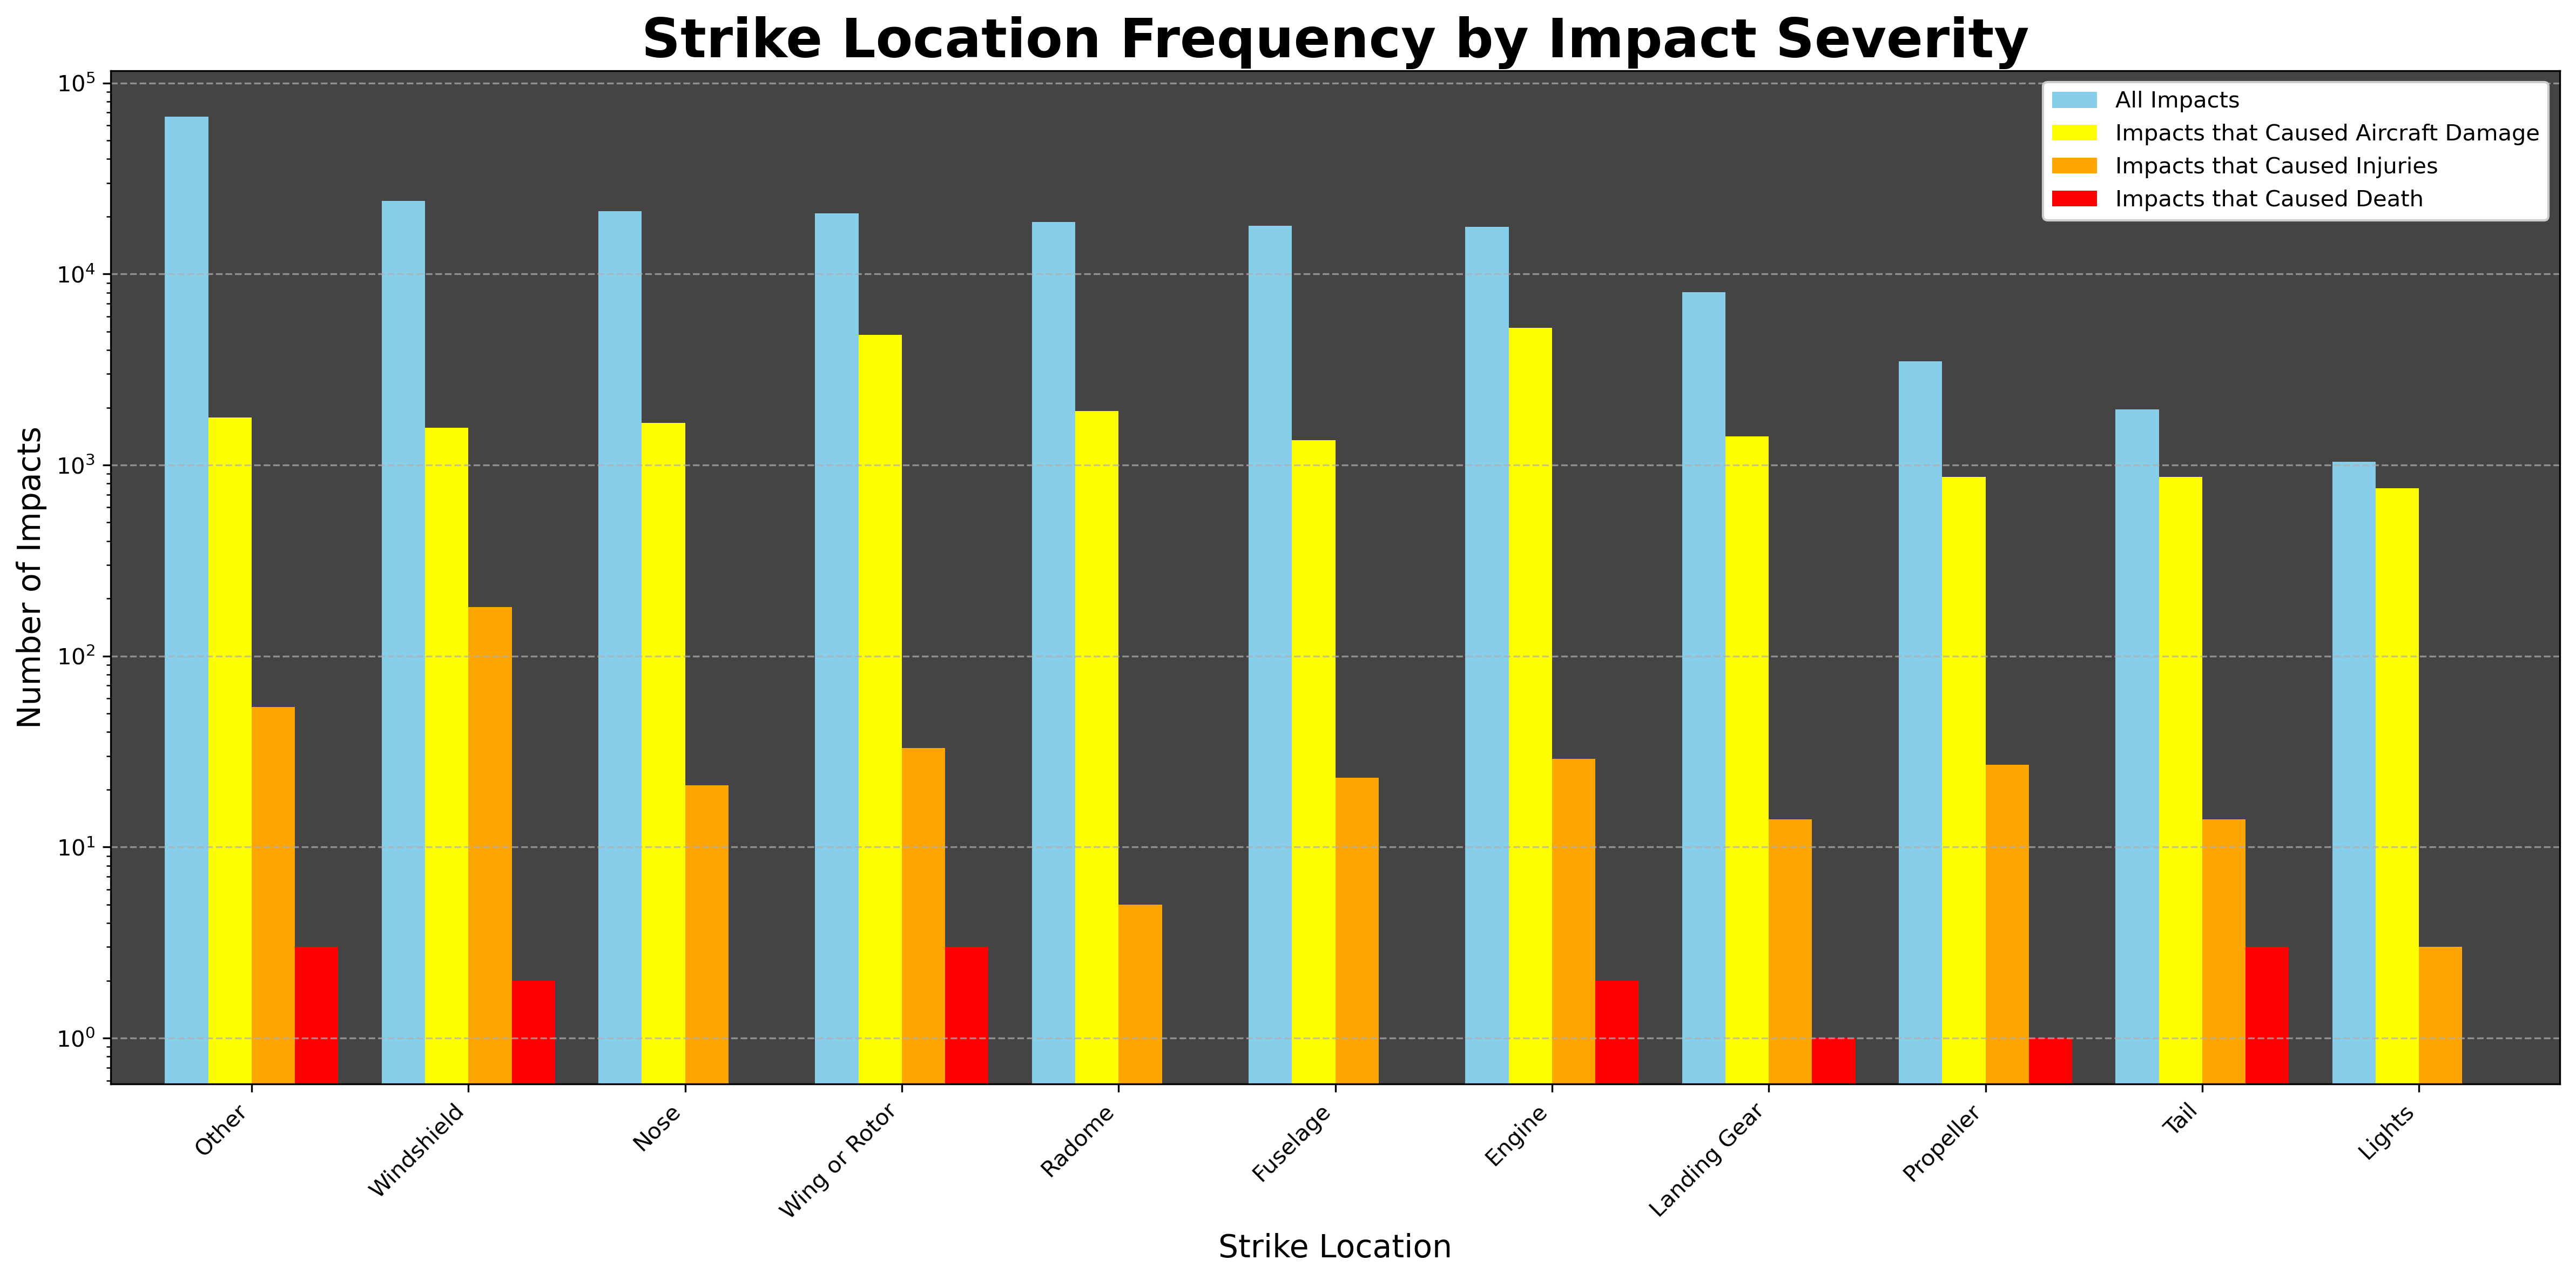

In [10]:
def plotCategoricalSeverity(inputArg):
    # Case 1: Input is a list (specifically for strikeCols)
    if isinstance(inputArg, list):
        allImpacts = impacts[inputArg].sum()
        damagedFlights = impacts[impacts["Aircraft Damage"] > 0][inputArg].sum()
        injuryFlights = impacts[impacts["Injuries"] > 0][inputArg].sum()
        fatalFlights = impacts[impacts["Fatalities"] > 0][inputArg].sum()
        title = "Strike Location"
        # Clean " Strike" from labels
        for s in [allImpacts, damagedFlights, injuryFlights, fatalFlights]:
            s.index = [i.replace(" Strike", "") for i in s.index]

    # Case 2: Standard Categorical Columns (Flight Phase or Visibility)
    else:
        allImpacts = impacts[inputArg].value_counts()
        damagedFlights = impacts[impacts["Aircraft Damage"] > 0][inputArg].value_counts()
        injuryFlights = impacts[impacts["Injuries"] > 0][inputArg].value_counts()
        fatalFlights = impacts[impacts["Fatalities"] > 0][inputArg].value_counts()
        title = inputArg

    # Combine into DataFrame with your specific labels
    plotData = pd.DataFrame({
        impactLabel: allImpacts,
        damageLabel: damagedFlights,
        injuryLabel: injuryFlights,
        fatalityLabel: fatalFlights
    }).fillna(0)
    
    # Sort by total impacts descending
    plotData = plotData.sort_values(impactLabel, ascending=False)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(16, 8))
    plotData.plot(
        kind="bar", 
        ax=ax, 
        color=[impactColor, damageColor, injuryColor, deathColor], 
        width=0.8
    )
    
    # Styling
    ax.set_title(f"{title} Frequency by Impact Severity", fontweight="bold", fontsize=24)
    ax.set_yscale("log")
    ax.set_facecolor(backgroundColor)
    ax.grid(axis="y", which="major", linestyle="--", alpha=0.7)
    ax.set_xlabel(title, fontsize=14)
    ax.set_ylabel("Number of Impacts", fontsize=14)
    
    plt.xticks(rotation=45, ha='right')
    plt.legend(facecolor="w", framealpha=1)
    
    fig.patch.set_facecolor("w")
    fig.set_dpi(300)
    plt.tight_layout()
    plt.show()

plotCategoricalSeverity(strikeLocations)

In [ ]:
plotCategoricalSeverity("Flight Phase")

In [ ]:
plotCategoricalSeverity("Visibility")

In [ ]:
plotCategoricalSeverity("Species Quantity")